# Definitions

In [1]:
%run '../definitions.ipynb'

In [2]:
import h5py
from tqdm import tqdm

## Analysis functions

### Reading data

In [3]:
def get_wf(f, n):
    ds = f['Waveforms']['Channel 1']['Channel 1 Seg%dData' % (n + 1)]
    return ds.value

def get_n_events(f):
    ds_thing = f['Waveforms']['Channel 1']
    return len(ds_thing.keys())

def read_file(number):
    data_path = '/home/erik/win/data/high_resolution/'
    filename = os.path.join(data_path, '%03d.h5' % number)
    f = h5py.File(filename, 'r')
    n_to_read = get_n_events(f)
    wfs = []
    for n in tqdm(range(n_to_read)):
        wfs.append(get_wf(f, n))
    return np.array(wfs)

### Auxilary functions

In [4]:
def estimate_pois(wfs, bounds = (950, 1250)):
    low, high = bounds
    peak_indices = np.argmin(wfs, axis=1)
    n_in_range = np.sum((peak_indices >= low) & (peak_indices < high))
    n_samples_in_range = high - low
    bg_in_range = (len(wfs) - n_in_range)  / (np.max(peak_indices) - n_samples_in_range) * n_samples_in_range
    print('BG of %.1f expected, got %d counts' % (bg_in_range, n_in_range))
    frac = (n_in_range - bg_in_range) / len(peak_indices)
    print('Fraction is %.2f percent!' % (100 * frac))

### Baselining

In [5]:
def get_baselines(wfs, baseline_bounds):
    '''
    Obtain the average and the standard deviation of the baseline in the ranges specified in baseline_bounds.
    Returns arrays of nbaselines x nwaveforms for baseline and sigma.
    '''
    baselines = []
    sigmas = []
    for bounds in baseline_bounds:
        left, right = bounds
        baseline = np.average(wfs[:, left:right], axis=1)
        sigma = np.std(wfs[:, left:right], axis=1)
        baselines.append(baseline)
        sigmas.append(sigma)
    return np.array(baselines), np.array(sigmas)

In [6]:
def correct_baseline(wfs, baselines, baseline_bounds, method='single', n=0):
    if method == 'single':
        return wfs - baselines[n][:, None]
    elif method == 'interpolation':
        n0, n1 = n
        t0, t1 = np.average(baseline_bounds[[n0, n1]], axis=1) - 0.5 # t is the sample number
        b0, b1 = (baselines[n0], baselines[n1])
        slopes = (b1 - b0) / (t1 - t0)
        offsets = b0 - slopes * t0
        slope_array = np.repeat([np.arange(0, np.shape(wfs)[1])], np.shape(wfs)[0], axis=0) * slopes[:, None]
        return wfs - offsets[:, None] - slope_array
    else:
        raise ValueError('Invalid method.')

### Invert, integrate, find max

In [7]:
def invert_pulse(wfs):
    return - wfs

In [8]:
def integrate_pulses(wfs, bounds):
    return np.sum(wfs[:, bounds[0]:bounds[1]], axis=1) * 0.1 # in nVs

In [9]:
def find_max(wfs, bounds = None):
    '''
    Find the maximum value within `bounds`
    '''
    if bounds:
        left, right = bounds
    else:
        left, right = [0, len(wfs[0])]
    return np.max(wfs[:, left:right], axis=1)

### Cuts

In [10]:
def cut_height(wfs, bounds, plot=True, verbose=True):
    '''
    Cut the waveform array based on the maximum amplitude.
    '''
    max_vals = find_max(wfs)
    if plot:
        plt.hist(max_vals, bins=200, histtype='step')
        plt.yscale('log')
        plt.xlabel('Maximum (V)')
        plt.axvline(bounds[0])
        plt.show()
    sel = (max_vals >= bounds[0]) & (max_vals < bounds[1])
    if verbose: print('Passing %d of %d events (%.2f %%)' % (np.sum(sel), len(wfs), 100 * np.sum(sel) / len(wfs)))
    return wfs[sel]

In [11]:
def cut_area(wfs, integration_bounds, cutoff, plot=True, verbose=True):
    '''
    Cut the waveform array based on the maximum amplitude.
    '''
    areas = integrate_pulses(wfs, integration_bounds)
    if plot:
        plt.hist(areas, bins=200, histtype='step')
        plt.yscale('log')
        plt.xlabel('Area (nVs)')
        plt.axvline(cutoff)
        plt.show()
    sel = (areas > cutoff)
    if verbose: print('Passing %d of %d events (%.2f %%)' % (np.sum(sel), len(wfs), 100 * np.sum(sel) / len(wfs)))
    return wfs[sel]

In [12]:
def cut_noise(wfs, baseline_bounds, n, cutoff=0.0004, plot=True):
    bounds = baseline_bounds[n]
    left, right = bounds
    noise = np.std(wfs[:, left:right], axis=1)
    if plot:
        plt.hist(noise, bins=100, histtype='step')
        plt.axvline(cutoff)
    return wfs[noise < cutoff]

In [13]:
def cut_max_sample(wfs, bounds, plot=True, apply=True):
    '''
    Cut based on the position of the maximum index.
    '''
    max_sample = np.argmax(wfs, axis=1)
    if plot:
        plt.hist(max_sample, range=(900, 2000), bins=200, histtype='step')
        for _l in bounds:
            plt.axvline(_l, color='black')
        plt.show()
    if apply:
        sel = (max_sample >= bounds[0]) & (max_sample < bounds[1])
        print('Cut %d of %d events (%.2f percent)' % (np.sum(sel), len(wfs), 100 * (1 - np.sum(sel) / len(wfs))))
        return wfs[(max_sample >= bounds[0]) & (max_sample < bounds[1])]

### Alignment

In [14]:
def find_alignment_sample(wfs, area_bounds, fraction):
    '''
    Find the index of the sample that is closest to `fraction` fraction of total area in `bounds`.
    '''
    areas = integrate_pulses(wfs, area_bounds)
    wfs_fracs = np.cumsum(wfs[:, area_bounds[0] : area_bounds[1]], axis = 1) / areas[:, None] * 0.1
    alignment_samples = np.argmin(np.abs(wfs_fracs - fraction), axis=1) + area_bounds[0]
    return alignment_samples

In [15]:
def shift_wf(wf, nsamples):
    '''
    Shift nsamples to the right
    '''
    if nsamples == 0:
        return wf
    elif nsamples > 0:
        return np.concatenate([np.zeros(nsamples), wf[:-nsamples]])
    elif nsamples < 0:
        return np.concatenate([wf[-nsamples:], np.zeros(-nsamples)])

In [16]:
def align_wfs(wfs, alignment_samples, align_on_sample = 1100, extend_by = 100):
    '''
    Align the waveforms by `alignment_samples`. Extends all waveforms to account for extra zeros.
    '''
    shift_samples = alignment_samples - align_on_sample

    wfs_new = np.zeros(shape = np.shape(wfs))
    for i, (wf, shift) in enumerate(zip(wfs, shift_samples)):
        wfs_new[i] = shift_wf(wf, -shift)
    return wfs_new

### Gain determination

In [17]:
from scipy.integrate import quad

def gaus_noamp(x, mu, sigma):
    return gaus(x, 1, mu, sigma)


def get_gain(wfs, area_bounds, p0, fit_range, plot=True, **kwargs):
    # This is the factor from nVs to millions of electrons
    prefactor = 1/(50 * 1.6022e-19) * 1e-6 * 1e-9
    areas = integrate_pulses(wfs, area_bounds) * prefactor
    if plot:
        plt.hist(areas, histtype='step', bins=200)
        plt.yscale('log')
        for _l in fit_range:
            plt.axvline(_l)
        plt.show()
    popt, perr, m = fit_unbinned(areas, gaus_noamp, p0=p0, fit_range=fit_range, plot=plot, **kwargs)
    
    start = 0
    stop  = 100
    gain = quad(lambda x: x * gaus_noamp(x, *popt), start, stop)[0] / quad(lambda x: gaus_noamp(x, *popt), start, stop)[0]
    print('Found a gain of %f million.' % gain)
    return gain

### Filtering

In [18]:
# stolen from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
# Honestly no idea if butter filter is any good
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def filter_wfs(wfs, cutoff = 0.25, order = 6, shift = -25):
    '''
    Lowpass filter the waveforms.
    '''
    fs = 10.0       # sample rate, GHz
    wfs_new = np.zeros(shape = np.shape(wfs))
    for i, wf in enumerate(wfs):
        if shift == 0:
            wfs_new[i] = butter_lowpass_filter(wf, cutoff, fs, order)
        elif shift > 0:
            wfs_new[i] = np.concatenate([np.zeros(shift), butter_lowpass_filter(wf, cutoff, fs, order)[:-shift]])
        elif shift < 0:
            wfs_new[i] = np.concatenate([butter_lowpass_filter(wf, cutoff, fs, order)[-shift:], np.zeros(-shift)])
    return wfs_new

### Pulse averaging

In [19]:
def normalize(wfs, bounds):
    return wfs / np.sum(wfs[:, bounds[0]: bounds[1]], axis=1)[:,None]

def average_wf(wfs):
    return np.average(wfs, axis=0)

# Single file analysis

## Settings

In [20]:
baseline_bounds = np.array([
    [0, 900],
    [3000, 4000]
]
)

## Read

In [21]:
wfs = read_file(76)

 57%|█████▋    | 18703/32768 [00:40<00:26, 528.34it/s]

KeyboardInterrupt: 

## Check the Poissoian percentage

First check: how many photons do we have, roughly? Should be about 5 percent.

In [ ]:
plt.hist(np.argmin(wfs, axis=1), histtype='step', bins=200)
plt.axvline(950)
plt.axvline(1250)

plt.show()

In [ ]:
estimate_pois(wfs)

## Baseline correction

Here we define a temporary selection just to see where we should put the baseline bounds

In [ ]:
good = (np.argmin(wfs, axis=1) > 1050) & (np.argmin(wfs, axis=1) < 1100) 

In [ ]:
plt.plot(wfs[good][0])
for bounds, c in zip(baseline_bounds, ['black', 'green', 'red', 'orange']):
    for _l in bounds:
        plt.axvline(_l, color=c)
plt.show()

In [ ]:
baselines, sigmas = get_baselines(wfs, baseline_bounds)

In [ ]:
wfs = correct_baseline(wfs, baselines, baseline_bounds, method='interpolation', n = (0, 1))

In [ ]:
wfs = invert_pulse(wfs)

## Gain...

Let us cut on the photons...

In [ ]:
gain = get_gain(wfs, (1000, 1200), p0=[4,3], fit_range= [1, 15], delay_fit = False, plot=True, plot_guess = False,
         print_level = 0, stfu = True)

In [ ]:
wfs_sel = cut_height(wfs, [0.002, np.inf])

## Alignment

In [ ]:
alignment_samples = find_alignment_sample(wfs_sel, (1000, 2000), 0.1)

In [ ]:
plt.hist(alignment_samples, bins=100, histtype='step')
plt.show()

In [ ]:
what = wfs_sel[alignment_samples > 1250]

In [ ]:
for i in range(10):
    plt.plot(wfs_sel[i], color='blue', alpha = 0.25)
for i in range(10):
    plt.plot(what[i], color='red', alpha = 0.25)

It looks like the late pulses are legit photons. Light travel time cannot explain the 20 ns delay. It is plobably the LED pulse itself. We can choose to either cut them or keep them.

In [ ]:
wfs_sel = cut_max_sample(wfs_sel, [1050, 1200])

In [ ]:
alignment_samples = find_alignment_sample(wfs_sel, (1000, 1200), 0.1)

In [ ]:
alignment_samples

In [ ]:
wfs_sel_al = align_wfs(wfs_sel, alignment_samples, extend_by=150)

In [ ]:
for i in range(10):
    plt.plot(wfs_sel[i])
plt.xlim(1000, 1450)
plt.title('Before alignment')

In [ ]:
for i in range(10):
    plt.plot(wfs_sel_al[i])
plt.xlim(1050, 1500)
plt.title('After alignment')

In [ ]:
ding =  normalize(wfs_sel_al, (1150, 1500))

In [ ]:
for i in range(10):
    plt.plot(ding[i])
plt.xlim(1050, 2000)
plt.title('After alignment and normalization')

In [ ]:
dt = 0.1 # ns
nsamples = 4096 + 2 * 150
t = np.arange(0, nsamples * dt, dt) - 1200 * dt

In [ ]:
plt.plot(t, average_wf(ding))
plt.xlim(-10, 200)

In [ ]:
plt.plot(t, average_wf(ding))

for wf in ding[:20]:
    plt.plot(t, wf, color='black', alpha=0.25)
plt.plot(t, average_wf(ding))

plt.xlim(-10, 100)

In [ ]:
wfs_f = filter_wfs(ding)

In [ ]:
plt.plot(t, average_wf(wfs_f), label='Filtered')
plt.plot(t, average_wf(ding), label='')
plt.xlim(-10, 200)
plt.legend()

## Check for area dependence

In [ ]:
areas = integrate_pulses(wfs_sel, (1000, 1200))

In [ ]:
slices = np.linspace(0, 0.16, 9)

In [ ]:
for left, right in zip(slices[:-1], slices[1:]):
    _wfs = ding[(areas > left) & (areas < right)] 
    plt.plot(t, average_wf(_wfs), label='Area %.2f +- 0.01' % (0.5 * (left + right)))
plt.legend(loc=(1,0))
plt.xlim(-10, 100)
plt.show()

In [ ]:
plt.hist(areas, histtype='step', bins=25)
plt.show()

In [ ]:
len(_wfs)

In [ ]:
plt.plot(_wfs[2])

# Reading more files...

## Data files

In [20]:
pmt1low_dsets  = [i for i in range(70, 76, 1)]
pmt1high_dsets = [i for i in range(76, 82, 1)]
pmt2low_dsets  = [i for i in range(48, 54, 1)]
pmt2high_dsets = [i for i in range(45, 48, 1)]

dsets = [
    pmt1low_dsets,
    pmt1high_dsets,
    pmt2low_dsets,
    pmt2high_dsets,    
]

## Settings

In [21]:
baseline_bounds = np.array([
    [0, 900],
    [3000, 4000]
]
)

In [22]:
integration_bounds = [1000, 1400]
alignment_sample = 1100
aligned_integration_bounds = (1000, 1300)

In [23]:
position_cuts = [1000, 1400]

## Correct and cut function

This function takes the raw waveforms, corrects baseline, inverts, cuts on height and max sample position, aligns and returns waveforms.

Steps stil missing after this: cut on noise, cut on area, gain fitting (if required), normalizing, averaging.

In [24]:
def analyze_it(wfs, baseline_bounds, integration_bounds, position_cuts, height_cutoff = 0.002, align_on_sample=1100, plot=True):
    # First estimate fraction of pulses...
    estimate_pois(wfs, bounds = integration_bounds)
    
    print('Computing baselines...')
    # Step 1: compute baselines and subtract
    baselines, sigmas = get_baselines(wfs, baseline_bounds)
    wfs = correct_baseline(wfs, baselines, baseline_bounds, method = 'interpolation', n = (0, 1))
    # Step 2: invert pulse
    wfs = invert_pulse(wfs)
    # Step 3: cut on height
    wfs = cut_height(wfs, (height_cutoff, np.inf), plot=plot)
    if plot: plt.show()
    # Step 4: cut on photon position
    wfs = cut_max_sample(wfs, [1000, 1400], plot=plot)
    if plot: plt.show()    
    # Step 5: align pulses
    alignment_samples = find_alignment_sample(wfs, integration_bounds, 0.1)
    wfs = align_wfs(wfs, alignment_samples, align_on_sample=align_on_sample)
    
    return wfs


## One dataset

In [ ]:
wfs = read_file(45)

In [ ]:
wfs = analyze_it(wfs, baseline_bounds, integration_bounds, position_cuts)

In [ ]:
for wf in wfs[:10]:
    plt.plot(wf)
plt.xlim(1000, 1200)

In [ ]:
wfs = cut_noise(wfs, baseline_bounds, 0)

In [ ]:
get_gain(wfs, integration_bounds, (4,4), (2, 20))

In [ ]:
wfs = cut_area(wfs, integration_bounds, 0.015)

## All datasets

### Settings and functions

In [28]:
highstat = True

In [ ]:
labels = ['PMT1 850V', 'PMT1 900V', 'PMT2 900V', 'PMT2 950V']
dt = 0.1
samples = 4096
alignment_sample = 1100
t = np.arange(0, samples * dt, dt) - alignment_sample * dt

### Reading the data

In [29]:
d = []
for dset_list in dsets:
    if highstat: 
        dsets_to_scan = dset_list
    else:
        dsets_to_scan = [dset_list[0]]
    wfs_this_setting = []
    for dset in dsets_to_scan:
        wfs = read_file(dset)
        wfs = analyze_it(wfs, baseline_bounds, integration_bounds, position_cuts, plot=False)
        wfs_this_setting.append(wfs)
    wfs_this_setting  = np.concatenate(wfs_this_setting)
    d.append(wfs_this_setting)


100%|██████████| 32768/32768 [01:05<00:00, 498.80it/s]


BG of 3056.9 expected, got 4530 counts
Fraction is 4.50 percent!
Computing baselines...
Passing 1317 of 32768 events (4.02 %)
Cut 1301 of 1317 events (1.21 percent)


100%|██████████| 32768/32768 [01:05<00:00, 498.92it/s]


BG of 3057.0 expected, got 4529 counts
Fraction is 4.49 percent!
Computing baselines...
Passing 1329 of 32768 events (4.06 %)
Cut 1319 of 1329 events (0.75 percent)


100%|██████████| 32768/32768 [01:02<00:00, 522.97it/s]


BG of 3067.3 expected, got 4434 counts
Fraction is 4.17 percent!
Computing baselines...
Passing 1263 of 32768 events (3.85 %)
Cut 1258 of 1263 events (0.40 percent)


100%|██████████| 32768/32768 [01:01<00:00, 532.53it/s]


BG of 3067.2 expected, got 4435 counts
Fraction is 4.17 percent!
Computing baselines...
Passing 1302 of 32768 events (3.97 %)
Cut 1292 of 1302 events (0.77 percent)


100%|██████████| 32768/32768 [01:02<00:00, 523.82it/s]


BG of 3058.4 expected, got 4516 counts
Fraction is 4.45 percent!
Computing baselines...
Passing 1361 of 32768 events (4.15 %)
Cut 1352 of 1361 events (0.66 percent)


 73%|███████▎  | 24031/32768 [00:44<00:14, 585.52it/s]

KeyboardInterrupt: 

### Further cuts, and gain

In [ ]:
avg_wfs = []
for i, wfs in enumerate(d):
    wfs = cut_noise(wfs, baseline_bounds, 0, plot=True)
    plt.show()
    wfs = cut_area(wfs, aligned_integration_bounds, 0.015, plot=True)
    plt.show()
    wfs = normalize(wfs, bounds=aligned_integration_bounds)
    wf = average_wf(wfs)
    d[i] = wfs
    avg_wfs.append(wf)

### Show the average waveforms

In [ ]:
for wf, l in zip(avg_wfs[:2], labels[:2]):
    plt.plot(t, wf, label=l)
plt.xlim(-10, 100)
plt.title('PMT 1')
plt.legend()
plt.show()

In [ ]:
for wf, l in zip(avg_wfs[2:], labels[2:]):
    plt.plot(t, wf, label=l)
plt.xlim(-10, 100)
plt.title('PMT 2')
plt.legend()
plt.show()

### Dump to pickle!

In [ ]:
with open('../pulse_shapes/pickles/highrespulse_ch0.pickle', 'wb') as f:
    pickle.dump((t, avg_wfs[2]), f)

In [ ]:
with open('../pulse_shapes/pickles/highrespulse_ch1.pickle', 'wb') as f:
    pickle.dump((t, avg_wfs[0]), f)

### Pretty plot of average wf

In [ ]:
wfs = d[0]

In [ ]:
for wf in wfs[:100]: 
    plt.plot(t, wf, color='black', alpha=0.1)
plt.plot(t, avg_wfs[0])
plt.xlim(-10, 100)

## Compare to low resolution pulses

### One example...

Here we take a random waveform and apply the rebinning to show its effect... 

In [ ]:
wfs = d[0]
wf = wfs[0]

In [ ]:
wc = rebin(wf, 20)

In [ ]:
tfine = np.arange(0, len(wf) * 0.1, 0.1)

In [ ]:
plt.plot(tc + 2 , wc, ls='steps', label='Ugly blunt course waveform')
plt.plot(tfine, wf * 20, ls='steps', label = "Fine-lookin' waveform buddy!")
plt.legend()
plt.xlim(100, 200)

## Defs

### Compute the course average waveform

To get what we would have gotten, we take the following approach:
  * Take the fine waveform and re-misalign it
  * Rebin it in bins of 2 ns
  * Align on max sample
  * Take a big average

In [26]:
def rebin(wf, n):
    n_bins = len(wf) // n
    wf = wf[:(n_bins * n)]
    wf = wf.reshape((n_bins, n))
    return np.sum(wf, axis=1)

In [27]:
def get_coarse_avg_waveform(wfs):
    
    wc = []
    for wf in wfs:
        # first destroy the alignment by shifting to random position in bin
        _w = shift_wf(wf, np.random.randint(0, 20))
        _wc = rebin(_w, 20)
        max_sample = np.argmax(_wc)
        # align course waveform
        align_on = 55
        _wc = shift_wf(_wc, align_on - max_sample)
        wc.append(_wc)
    return np.average(wc, axis=0)

In [28]:
dset_ch0 = '170323_103732' # Top PMT
dset_ch1 = '170323_104831' # Bottom PMT

pulse_ch0 = pickle.load(open('../pulse_shape_single_pe/%s_ch%d.pickle' % (dset_ch0, 0) , 'rb'))
pulse_ch1 = pickle.load(open('../pulse_shape_single_pe/%s_ch%d.pickle' % (dset_ch1, 1) , 'rb'))

t_cold = np.linspace(0, 639*2, 640) - 340 * 2
# Aligned on sample 340

In [29]:
tc = np.arange(0, 408, 2)

### Compare to cold calibration

In [ ]:
wfs = d[0]
wc = get_coarse_avg_waveform(wfs)

In [ ]:
plt.plot(tc, wc, linestyle = 'steps', label='Average')
plt.xlim(100, 200)

#### PLOT PMT1!

In [ ]:
wfs = d[0]
wc = get_coarse_avg_waveform(wfs)

norm_range = (-10, 25)
a1 = 1 / sum(pulse_ch1[(t_cold >= norm_range[0]) & (t_cold < norm_range[1])])
a2 = 1 / sum(wc[(tc - 110 >= norm_range[0]) & (tc - 110 < norm_range[1])])

plt.plot(t_cold, a1 * pulse_ch1, label='Cold calibration', ls = 'steps')
plt.plot(tc - 110, a2 * wc, label='Warm calibration', ls='steps')
plt.legend()
plt.xlim(-20, 200)
# plt.ylim(-0.02, 0.07)
plt.title('PMT1')
plt.show()

#### PLOT PMT2!

In [ ]:
wfs = d[2]
wc = get_coarse_avg_waveform(wfs)

In [ ]:
a1 = 1 / sum(pulse_ch0[(t_cold >= norm_range[0]) & (t_cold < norm_range[1])])
a2 = 1 / sum(wc[(tc - 110 >= norm_range[0]) & (tc - 110 < norm_range[1])])

plt.plot(t_cold, a1 * pulse_ch0, label='Cold calibration', ls = 'steps')
plt.plot(tc - 110, a2 * wc, label='Warm calibration', ls='steps')
plt.legend()
plt.xlim(-20, 200)
# plt.ylim(-0.02, 0.07)
plt.title('PMT2')
plt.show()

## FFT...

What are the ringing frequencies?

In [ ]:
wf = wfs[0]

In [ ]:
time_range = (20, 300)

In [ ]:
dt = 0.1
t = np.linspace(0, 4096 * dt, 4096)

In [ ]:
plt.plot(t, wf)
for _l in time_range:
    plt.axvline(_l)
plt.xlabel('Time (ns)')

In [ ]:
sel = (t >= time_range[0]) & (t < time_range[1])
wf_sel = wf

In [ ]:
wf_sel = wfs[1]

In [ ]:
yfs = []
for wf_sel in wfs[:100]:
    fft = np.fft.fft(wf_sel)
    N = len(wf_sel)
    xf = np.linspace(0.0, 1 / (2 * dt), N/2)
    yf = np.abs(fft[:N//2])
    # kill zero component
    yf[0] = 0
    yfs.append(yf)

In [ ]:
yf = np.average(yfs, axis=0)

In [ ]:
plt.plot(xf * 1000, yf**2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Spectral power')
plt.xlim(0, 2000)
#plt.text(1200, 0.002, "Note: adjusted ylim")
# plt.savefig('noise_power_3.png')

In [ ]:
def find_peaks(xf, yf, level):
    return xf[yf**2 > level] * 1000

In [ ]:
find_peaks(xf, yf, 0.008)

In [ ]:
delta_f = np.diff(xf)[0] * 1000

In [ ]:
plt.plot(xf * 1000, yf**2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Spectral power')
plt.xlim(0, 200)
for i in [12, 14, 24.5, 31, 47.5, 50]:
    plt.axvline(delta_f * i)
    print('One at %.1f MHz...' % (delta_f * i))

In [ ]:
plt.plot(t, wf)
plt.xlabel('Time (ns)')
plt.xlim(0, 100)
# plt.ylim(-0.002, 0.002)
plt.grid()
plt.axvline(25 - 2 * 11.4)
plt.axvline(25 - 11.4)
plt.axvline(25)
plt.axvline(82)

5 oscillations in (82 - 25) ns

In [ ]:
T = (82 - 25) / 5
print(1/T * 1000)

That is also the dominant peak in the FFT: 88 MHz. What is the corresponding wavelength in a cable with typical velocity factor of 0.75?

In [ ]:
300 / 88 * 0.75 # velocity factor of 0.75

Sounds legit. The peak-first max delay time found in the MSc thesis is 19.5 ns, here it is 11.5 ns, giving:

In [ ]:
1/19.5 * 1000

In [ ]:
1/11.5 * 1000

In [ ]:
# http://sound.whsites.net/articles/coax.htm

In [ ]:
plt.plot(t, wf)
plt.xlabel('Time (ns)')
plt.xlim(0, 30)
# plt.ylim(-0.002, 0.002)
plt.grid()
plt.axvline(1.5)
plt.axvline(13)

### PMT2

In [ ]:
wf = avg_wfs[2]
wf_sel = wf[sel]


In [ ]:
plt.plot(wf_sel)

In [ ]:
fft = np.fft.fft(wf_sel)
N = len(wf_sel)
xf = np.linspace(0.0, 1 / (2 * dt), N/2)
yf = np.abs(fft[:N//2])

In [ ]:
plt.plot(xf * 1000, yf**2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Spectral power')
plt.xlim(0, 200)
for i in [12.5, 16, 29.5, 33]:
    plt.axvline(delta_f * i)
    print('One at %.1f MHz...' % (delta_f * i))
plt.axvline()

The dominant frequency in PMT2 is 57.3 MHz. This means... Let us compare the first split line structure....

In [ ]:
f1 = np.array([42.9 , 50.1])
f2 = np.array([44.7, 57.3])

In [ ]:
l1 = 300 / f1 * 0.75

In [ ]:
l2 = 300 / f2 * 0.75

assuming this is the base frequency, the cable length is half this. So,


In [ ]:
dl = 0.5 * (l1 - l2)

In [ ]:
dl

10 - 30 cm. Hmm. Not that bad.

### Conclusion...

It looks like we have a frequency of ~ 87 MHz (11.5 ns), and also half this frequency and the harmonics. This could correspond to standing waves in the cable, as about 2.5 m of cable would give us these kind of frequencies (half wave of 50 MHz is approximately this length). This would mean that the cable length influences the pulse. For the MSc calibration, there was probably a different cable length (unknown...) giving 19.5 ns from max to first next peak, instead of 11.5. A pretty significant difference! Some information: @  http://sound.whsites.net/articles/coax.htm

Incidentally, the cable length with the high-resolution pulse is almost exactly the same (lucky enough!) as the one for normal data. It looks like the high-res cable length is about < 10 cm longer.

# Pretty plot

First execute the function def, then the part at 'all datasets', then come back.

In [40]:
dsets_to_scan = dsets[2] # PMT1 850 V


wfs_this_setting = []
for dset in dsets_to_scan:
    wfs = read_file(dset)
    wfs = analyze_it(wfs, baseline_bounds, integration_bounds, position_cuts, plot=False)
    wfs_this_setting.append(wfs)


100%|██████████| 32768/32768 [00:31<00:00, 1031.94it/s]


BG of 3047.8 expected, got 4614 counts
Fraction is 4.78 percent!
Computing baselines...
Passing 1487 of 32768 events (4.54 %)
Cut 1376 of 1487 events (7.46 percent)


100%|██████████| 32768/32768 [00:31<00:00, 1050.89it/s]


BG of 3043.0 expected, got 4658 counts
Fraction is 4.93 percent!
Computing baselines...
Passing 1526 of 32768 events (4.66 %)
Cut 1447 of 1526 events (5.18 percent)


100%|██████████| 32768/32768 [00:25<00:00, 1265.32it/s]


BG of 3058.6 expected, got 4514 counts
Fraction is 4.44 percent!
Computing baselines...
Passing 1341 of 32768 events (4.09 %)
Cut 1327 of 1341 events (1.04 percent)


100%|██████████| 32768/32768 [00:26<00:00, 1252.50it/s]


BG of 3054.4 expected, got 4553 counts
Fraction is 4.57 percent!
Computing baselines...
Passing 1354 of 32768 events (4.13 %)
Cut 1338 of 1354 events (1.18 percent)


100%|██████████| 32768/32768 [00:27<00:00, 1211.62it/s]


BG of 3052.4 expected, got 4571 counts
Fraction is 4.63 percent!
Computing baselines...
Passing 1440 of 32768 events (4.39 %)
Cut 1409 of 1440 events (2.15 percent)


100%|██████████| 32768/32768 [00:27<00:00, 1176.19it/s]


BG of 3052.3 expected, got 4572 counts
Fraction is 4.64 percent!
Computing baselines...
Passing 1365 of 32768 events (4.17 %)
Cut 1354 of 1365 events (0.81 percent)


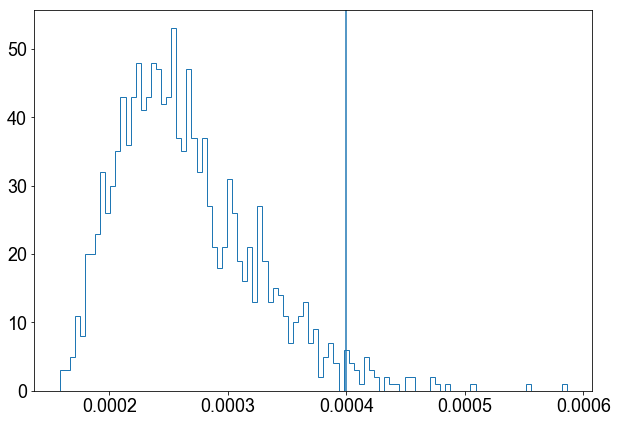

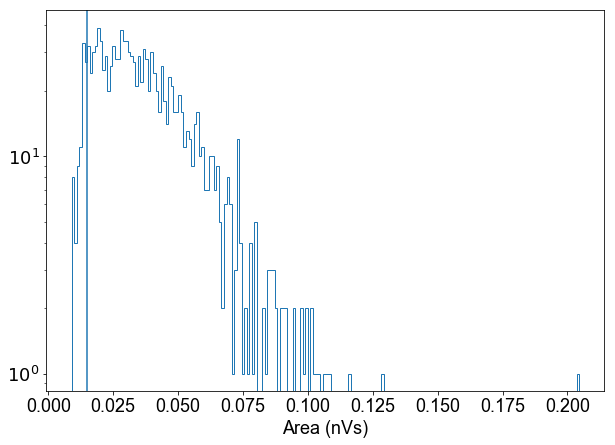

Passing 1224 of 1318 events (92.87 %)


In [41]:
wfs = cut_noise(wfs, baseline_bounds, 0, plot=True)
plt.show()
wfs = cut_area(wfs, aligned_integration_bounds, 0.015, plot=True)
plt.show()
wfs = normalize(wfs, bounds=aligned_integration_bounds)
wf = average_wf(wfs)

In [42]:
pickle.dump(wfs, open('/home/erik/win/data/pmt1_highrespulse.pickle', 'wb'))

In [39]:
dt = 0.1
samples = 4096
alignment_sample = 1100
t = np.arange(0, samples * dt, dt) - alignment_sample * dt

(-10, 100)

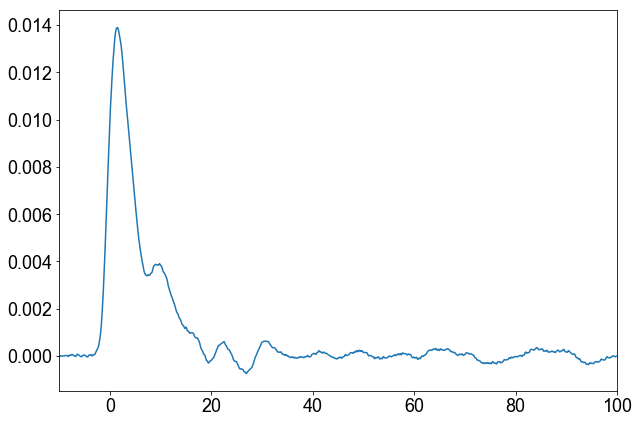

In [41]:
plt.plot(t, wf)
plt.xlim(-10,100)

In [55]:
def get_width(t, wf):
    halfmax = 0.5 * np.max(wf)
    halfpoints = t[np.concatenate([[False], np.diff(wf > halfmax)])]
    return halfpoints[1] - halfpoints[0]

In [56]:
get_width(t, wf)

5.3000000000000114

In [62]:
wc = get_coarse_avg_waveform(wfs)

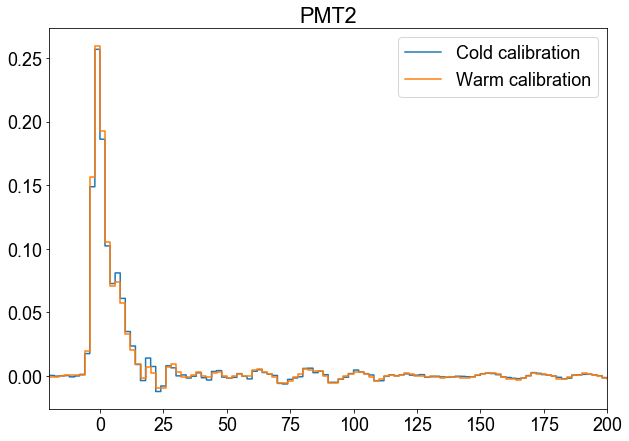

In [68]:
norm_range = (-10, 25)
a1 = 1 / sum(pulse_ch0[(t_cold >= norm_range[0]) & (t_cold < norm_range[1])])
a2 = 1 / sum(wc[(tc - 110 >= norm_range[0]) & (tc - 110 < norm_range[1])])

plt.plot(t_cold, a1 * pulse_ch0, label='Cold calibration', ls = 'steps')
plt.plot(tc - 110, a2 * wc, label='Warm calibration', ls='steps')
plt.legend()
plt.xlim(-20, 200)
# plt.ylim(-0.02, 0.07)
plt.title('PMT2')
plt.show()

# Uncertainty on the SPE model

In [30]:
# The dataframes containing all the pulses with proper waveforms
all_wfs = [
    pickle.load(open('/home/erik/win/data/pmt1_highrespulse.pickle', 'rb')), # WARNING the filenames are flipped!
    pickle.load(open('/home/erik/win/data/pmt2_highrespulse.pickle', 'rb'))
    ]
# The average pulses from the cold PMT calibration @ 2 ns, aligned on max sample
pmtpulses = [pulse_ch0, pulse_ch1]

# The high resolution pulses as used by the minimization procedure
highres_pulses = [
    pickle.load(open('/data/xenon/ehogenbi/pulsefit/pickles/highrespulse_ch0.pickle', 'rb')),
    pickle.load(open('/data/xenon/ehogenbi/pulsefit/pickles/highrespulse_ch1.pickle', 'rb')),
]

In [31]:
pmtindex = 0

Coarse waveforms should be shifted 1.400000 ns to the right


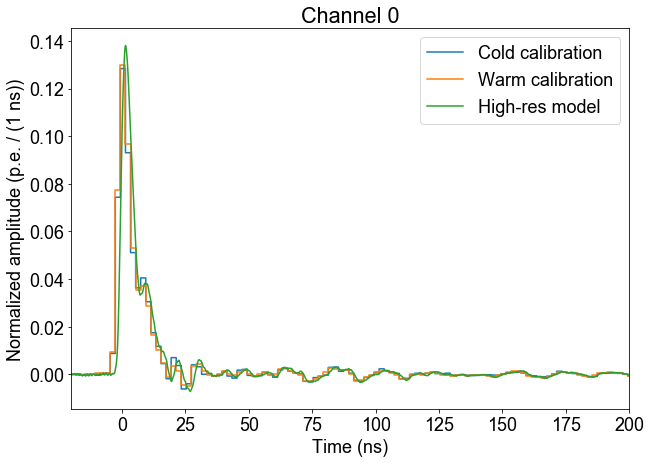

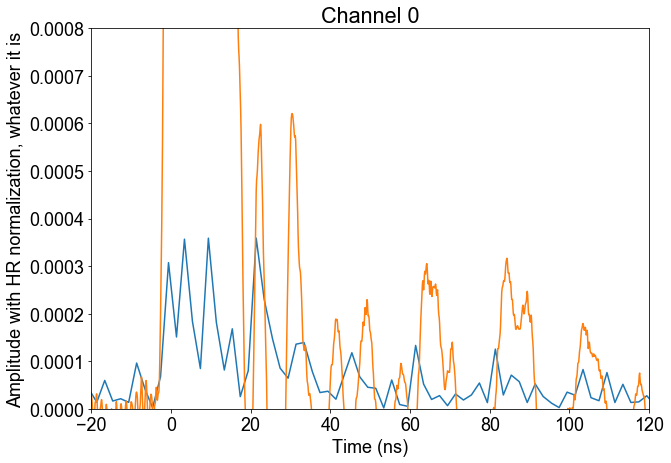

Pulse error reaches a max of 2.57 percent of max pulse...
Coarse waveforms should be shifted 1.400000 ns to the right


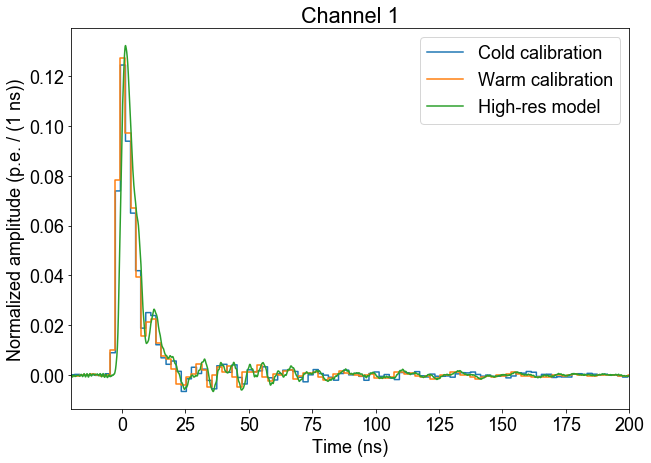

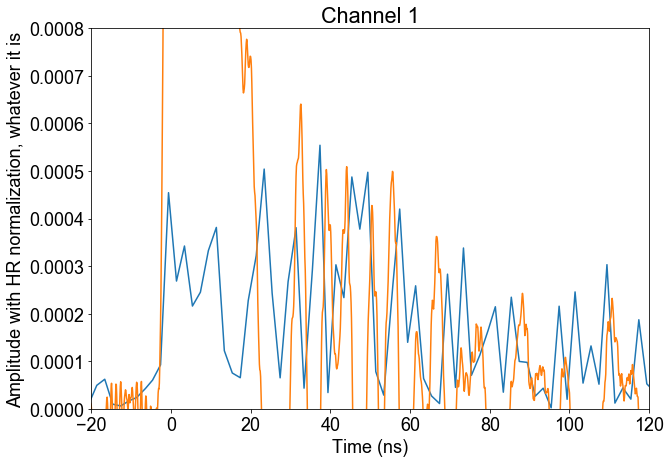

Pulse error reaches a max of 4.18 percent of max pulse...


In [33]:
pulse_errs = []
for pmtindex in [0, 1]:
    wfs = all_wfs[pmtindex]
    pulse = pmtpulses[pmtindex]
    wc = get_coarse_avg_waveform(wfs) # Coarse waveform from high-res data
    t_hr, p_hr = highres_pulses[pmtindex]

    # Norm range is required because of severe baseline issues in the cold calibration
    norm_range = (-10, 25)
    a1 = 1 / (sum(pulse[(t_cold >= norm_range[0]) & (t_cold < norm_range[1])]) * 2)
    a2 = 1 / (sum(wc[(tc - 110 >= norm_range[0]) & (tc - 110 < norm_range[1])]) * 2)
    a3 = 1 / (sum(p_hr[(t_hr >= norm_range[0]) & (t_hr < norm_range[1])]) * 0.1)

    t_shift = t_hr[np.argmax(p_hr)] - t_cold[np.argmax(pulse)] 
    print("Coarse waveforms should be shifted %f ns to the right" % t_shift)


    plt.plot(t_cold + t_shift, a1 * pulse, label='Cold calibration', ls = 'steps')
    plt.plot(tc - 110 + t_shift, a2 * wc, label='Warm calibration', ls='steps')
    plt.plot(t_hr, a3 * p_hr, label='High-res model')
    plt.legend()
    plt.xlim(-20, 200)
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (p.e. / (1 ns))')
    plt.title("Channel %d" % pmtindex)
    plt.show()

    # Get a universal time for the two coarse calibrations
    t_range = (-40, 298)
    t = np.arange(*t_range, step = 2)

    coldpulse = a1 * pulse[(t_cold >= t_range[0]) &  (t_cold < t_range[1])]
    hotpulse = a2 * wc[((tc - 110) >= t_range[0]) &  ((tc-110) < t_range[1])]

    pulse_err = np.abs(coldpulse - hotpulse)
    pulse_err_hr = np.interp(t_hr, t + t_shift, (1/a3) * pulse_err)
    plt.plot(t_hr, pulse_err_hr)
    plt.plot(t_hr, p_hr)
    plt.xlabel('Time (ns)')
    plt.ylabel('Amplitude with HR normalization, whatever it is')
    plt.ylim(0, 0.0008)
    plt.xlim(-20, 120)
    plt.title("Channel %d" % pmtindex)
    plt.show()
    print('Pulse error reaches a max of %.2f percent of max pulse...' % (100. * np.max(pulse_err_hr) / np.max(p_hr)))
    pulse_errs.append(pulse_err_hr)

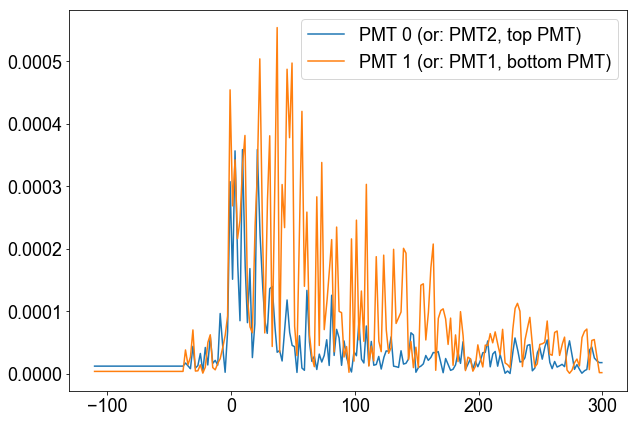

In [34]:
plt.plot(t_hr, pulse_errs[0], label='PMT 0 (or: PMT2, top PMT)')
plt.plot(t_hr, pulse_errs[1], label='PMT 1 (or: PMT1, bottom PMT)')
plt.legend()

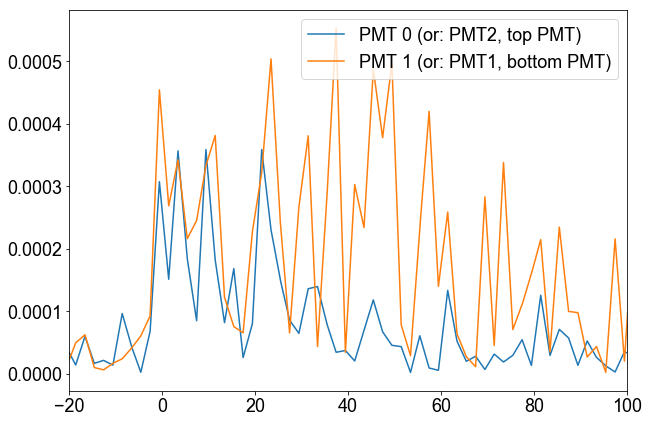

In [35]:
plt.plot(t_hr, pulse_errs[0], label='PMT 0 (or: PMT2, top PMT)')
plt.plot(t_hr, pulse_errs[1], label='PMT 1 (or: PMT1, bottom PMT)')
plt.xlim(-20, 100)
plt.legend()

In [36]:
# with open('/data/xenon/ehogenbi/pulsefit/pickles/highrespulse_error.pickle', 'wb') as f:
#     pickle.dump((t_hr, pulse_errs[0]), f)

(-10, 100)

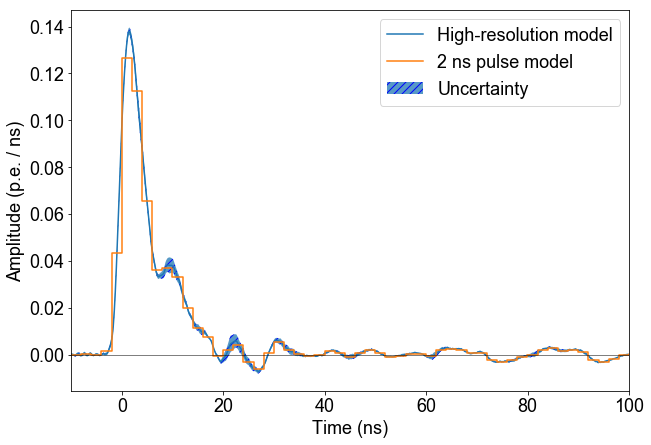

In [100]:
pmtindex = 0

wfs = all_wfs[pmtindex]
pulse = pmtpulses[pmtindex]
wc = get_coarse_avg_waveform(wfs) # Coarse waveform from high-res data
t_hr, p_hr = highres_pulses[pmtindex]

# Norm range is required because of severe baseline issues in the cold calibration
norm_range = (-10, 25)
a1 = 1 / (sum(pulse[(t_cold >= norm_range[0]) & (t_cold < norm_range[1])]) * 2)
a2 = 1 / (sum(wc[(tc - 110 >= norm_range[0]) & (tc - 110 < norm_range[1])]) * 2)
a3 = 1 / (sum(p_hr[(t_hr >= norm_range[0]) & (t_hr < norm_range[1])]) * 0.1)

t_shift = t_hr[np.argmax(p_hr)] - t_cold[np.argmax(pulse)] 


# Get a universal time for the two coarse calibrations
t_range = (-40, 298)
t = np.arange(*t_range, step = 2)

coldpulse = a1 * pulse[(t_cold >= t_range[0]) &  (t_cold < t_range[1])]
hotpulse = a2 * wc[((tc - 110) >= t_range[0]) &  ((tc-110) < t_range[1])]

pulse_err = np.abs(coldpulse - hotpulse)
pulse_err_hr = np.interp(t_hr, t + t_shift, (1/a3) * pulse_err)



plt.plot(t_hr, a3 * p_hr, label='High-resolution model')
mpl.rcParams['hatch.color'] = 'blue'
plt.fill_between(t_hr, a3 * p_hr - a3 * pulse_err_hr, a3 * p_hr + a3 * pulse_err_hr, label='Uncertainty',
                 alpha = 0.75, hatch='///' )


# plt.plot(rebin(t_hr, 20) / 20, rebin(a3 * p_hr, 20) / 20, ls='steps-mid')
def rebin_shift_normalize(t, p, n, shift=0):
    p = shift_wf(p, shift)
    t = t - shift * 0.1
    return (rebin(t, n) / n, rebin(p, n) / n)
    
# plt.plot(rebin(t_hr, 20) / 20, rebin(a3 * p_hr, 20) / 20, ls='steps-mid')
_t, _base = rebin_shift_normalize(t_hr, a3 * p_hr, 20, 0)
_,  _upper = rebin_shift_normalize(t_hr, a3 * (p_hr + pulse_err_hr), 20, 0)
_,  _lower = rebin_shift_normalize(t_hr, a3 * (p_hr - pulse_err_hr), 20, 0)
plt.plot(*rebin_shift_normalize(t_hr, a3 * p_hr, 20, 0),  ls='steps-mid', label='2 ns pulse model')
mpl.rcParams['hatch.color'] = 'red'
plt.fill_between(t_hr, a3 * p_hr - a3 * pulse_err_hr, a3 * p_hr + a3 * pulse_err_hr, label='Uncertainty',
                 alpha = 0.75, hatch='///' )

plt.axhline(color='black', lw= 0.5)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (p.e. / ns)')

plt.xlim(-10, 100)

(-10, 100)

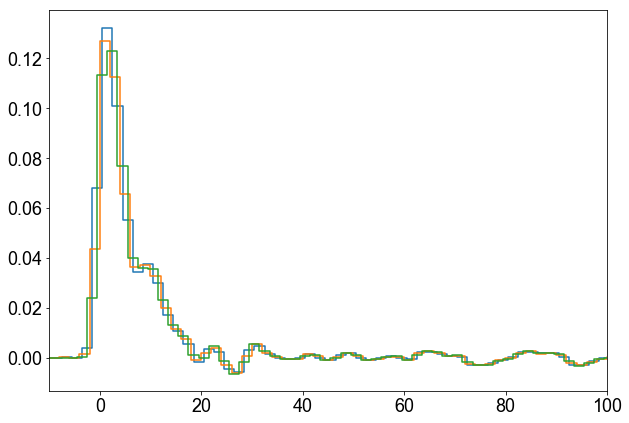

In [85]:
def rebin_shift_normalize(t, p, n, shift=0):
    p = shift_wf(p, shift)
    t = t - shift * 0.1
    return (rebin(t, n) / n, rebin(p, n) / n)
    
for sh in (-5, 0, +5):
    plt.plot(*rebin_shift_normalize(t_hr, a3 * p_hr, 20, sh),  ls='steps-mid')
# plt.plot(*rebin_shift_normalize(t_hr, a3 * p_hr, 20, 5),  ls='steps-mid')
# plt.plot(*rebin_shift_normalize(t_hr, a3 * p_hr, 20, -5),  ls='steps-mid')
plt.xlim(-10, 100)

In [40]:
np.sum(a3 * p_hr)

10.013901142616142

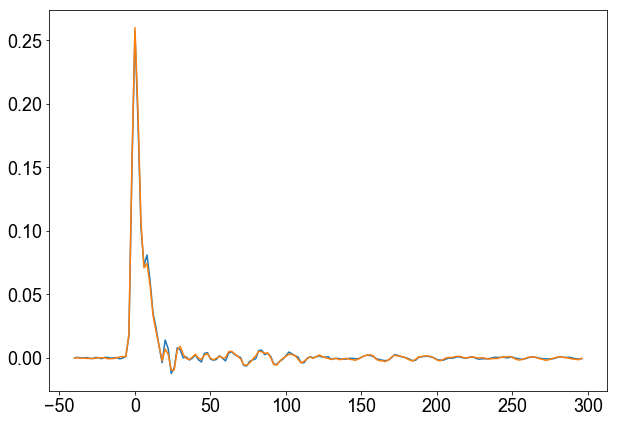

In [160]:
plt.plot(t, coldpulse)
plt.plot(t, hotpulse)

(0, 0.008429253370458514)

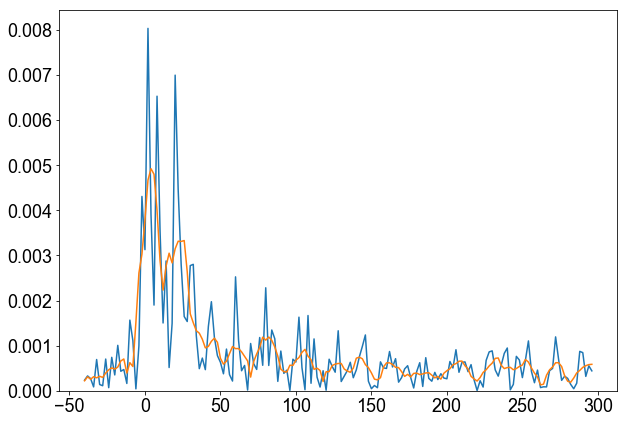

In [162]:
plt.plot(t, np.abs(coldpulse - hotpulse))
plt.plot(t, savitzky_golay(np.abs(coldpulse - hotpulse), window_size = 11, order = 3))
plt.ylim(0)

In [163]:
%run '../pulse_shapes/psd_mc_functions.ipynb'

Reading XAMS data from pickles...
Read data in 4.81 seconds


(-0.02, 0.02)

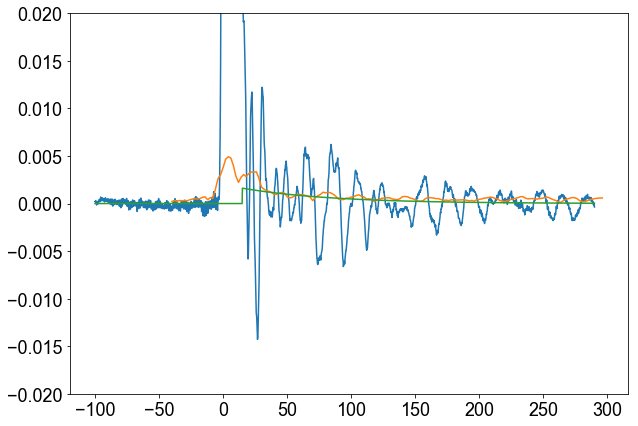

In [164]:
plt.plot(spe_ts_fine, 100 * spe_ys_fine[0])
plt.plot(t, savitzky_golay(np.abs(coldpulse - hotpulse), window_size = 11, order = 3))
plt.plot(spe_ts_fine, 100 *spe_dys_fine)
plt.ylim(-0.02, 0.02)

In [143]:
spe_dy_fine = np.interp(spe_ts_fine,
    t, savitzky_golay(np.abs(coldpulse - hotpulse), window_size = 11, order = 3))


In [165]:
ding = np.interp(spe_ts_fine,
    t, savitzky_golay(coldpulse, window_size = 11, order = 3))

In [166]:
np.sum(ding)

10.242142266271747

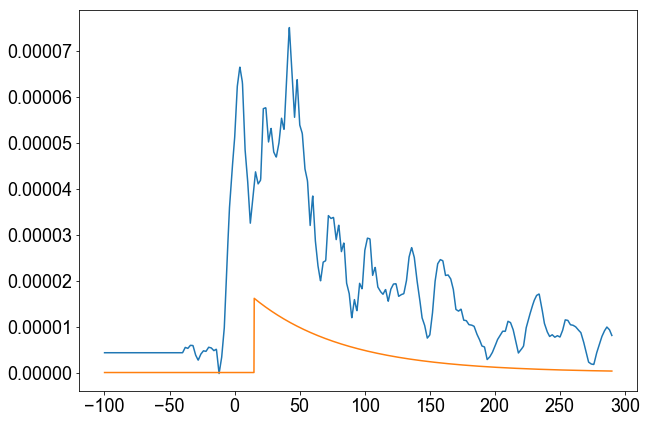

In [168]:
plt.plot(spe_ts_fine, 0.01 * spe_dy_fine)
plt.plot(spe_ts_fine, spe_dys_fine)

In [153]:
spe_dys_fine = 0.01 * spe_dy_fine

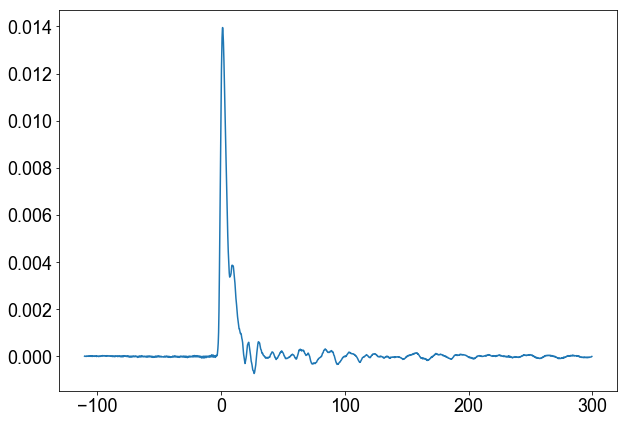

In [175]:
plt.plot(_t,_p)

In [178]:
def norm_pulse(t, p, pnorm=None):
    if pnorm is None:
        pnorm = p
    dt = np.diff(t)[0]
    return p / (np.sum(pnorm) * dt)

(0, 0.01)

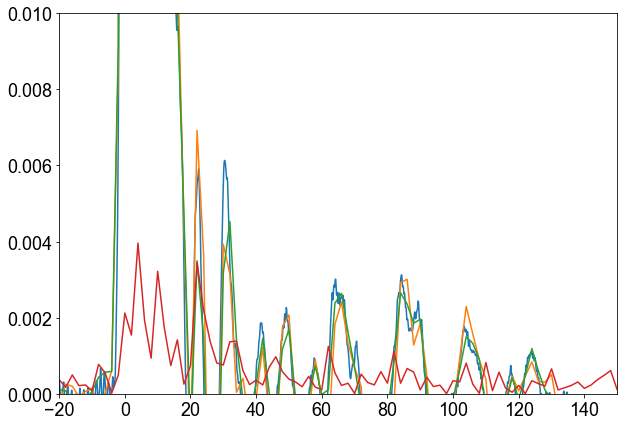

In [186]:
plt.plot(_t, norm_pulse(_t, _p))
plt.plot(t + 2, norm_pulse(t, coldpulse))
plt.plot(t + 2, norm_pulse(t, hotpulse))
plt.plot(t + 2, norm_pulse(t, np.abs(hotpulse - coldpulse), hotpulse))

plt.xlim(-20, 150)
plt.ylim(0, 0.01)